In [1]:
import utils
import numpy as np
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten,Dropout
from keras.layers import Conv2D,LSTM,BatchNormalization,MaxPooling2D,Reshape
from keras.utils import to_categorical
import matplotlib.pyplot as plt

In [2]:
# Load the Dataset

X_test = np.load("X_test.npy")
y_test = np.load("y_test.npy")
person_train_valid = np.load("person_train_valid.npy")
X_train_valid = np.load("X_train_valid.npy")
print(X_train_valid.shape)
y_train_valid = np.load("y_train_valid.npy")
person_test = np.load("person_test.npy")

y_train_valid -= 769
y_test -= 769


(2115, 22, 1000)


In [3]:
ind_valid = np.random.choice(2115, 200, replace=False)
ind_train = np.array(list(set(range(2115)).difference(set(ind_valid))))
(x_train, x_valid) = X_train_valid[ind_train], X_train_valid[ind_valid]
(y_train, y_valid) = y_train_valid[ind_train], y_train_valid[ind_valid]

# Shuffle the data after adding the noise to them so that the noisy examples 
# are not all together
x_train, y_train = utils.addNoisyExamplesToData(x_train, y_train, 6000, 0, 1)

indices = np.random.permutation(len(x_train))
x_train = x_train[indices]
y_train = y_train[indices]
print(x_train.shape)
print(y_train.shape)

y_train = to_categorical(y_train, 4)
y_valid = to_categorical(y_valid, 4)
y_test = to_categorical(y_test, 4)

# Reshape so that each example is three-dimensional 
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_valid = x_valid.reshape(x_valid.shape[0], x_valid.shape[1], x_valid.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Axis swapping
x_train = np.swapaxes(x_train, 1, 3)
x_train = np.swapaxes(x_train, 1, 2)
x_valid = np.swapaxes(x_valid, 1, 3)
x_valid = np.swapaxes(x_valid, 1, 2)
X_test = np.swapaxes(X_test, 1, 3)
X_test = np.swapaxes(X_test, 1, 2)

print(x_train.shape)

(7915, 22, 1000)
(7915,)
(7915, 1000, 1, 22)


In [4]:
cnn_model = Sequential()

# Given that this is time-series data, having a kernel that is more along one dimension (e.g. 15 by 1) is reasonable
# since there is not really much of a relationship between "square" tiles of the data but rather subsequent 
# tiles
cnn_model.add(Conv2D(filters=10, kernel_size=(15, 1), padding='same', activation='relu', input_shape=(1000, 1, 22)))
cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(filters=20, kernel_size=(10, 1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(filters=40, kernel_size=(5, 1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Conv2D(filters=60, kernel_size=(5, 1), padding='same', activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(3, 1), padding='same'))
cnn_model.add(BatchNormalization())
cnn_model.add(Dropout(0.5))

cnn_model.add(Flatten())
cnn_model.add(Dense(4, activation='softmax'))

cnn_model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 1000, 1, 10)       3310      
                                                                 
 max_pooling2d (MaxPooling2  (None, 334, 1, 10)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 334, 1, 10)        40        
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 334, 1, 10)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 334, 1, 20)        2020      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 112, 1, 20)        0

In [5]:
learning_rate = 1e-3
epochs = 250
cnn_model_optimizer = keras.optimizers.legacy.Adam(learning_rate=learning_rate)

In [6]:
# Compiling the model
cnn_model.compile(loss='categorical_crossentropy',
                 optimizer=cnn_model_optimizer,
                 metrics=['accuracy'])

# Training and validating the model
cnn_model_results = cnn_model.fit(x_train,
             y_train,
             batch_size=64,
             epochs=epochs,
             validation_data=(x_valid, y_valid), verbose=True)

Epoch 1/250
124/124 [==============================] - 6s 45ms/step - loss: 1.9741 - accuracy: 0.2815 - val_loss: 1.3244 - val_accuracy: 0.3200
Epoch 2/250
124/124 [==============================] - 5s 41ms/step - loss: 1.6043 - accuracy: 0.3093 - val_loss: 1.3149 - val_accuracy: 0.3350
Epoch 3/250
124/124 [==============================] - 5s 43ms/step - loss: 1.4498 - accuracy: 0.3411 - val_loss: 1.3623 - val_accuracy: 0.3350
Epoch 4/250
124/124 [==============================] - 5s 42ms/step - loss: 1.3442 - accuracy: 0.3842 - val_loss: 1.2744 - val_accuracy: 0.4300
Epoch 5/250
124/124 [==============================] - 6s 51ms/step - loss: 1.2762 - accuracy: 0.4190 - val_loss: 1.2828 - val_accuracy: 0.3500
Epoch 6/250
124/124 [==============================] - 6s 46ms/step - loss: 1.2115 - accuracy: 0.4569 - val_loss: 1.1920 - val_accuracy: 0.4200
Epoch 7/250
124/124 [==============================] - 6s 46ms/step - loss: 1.1665 - accuracy: 0.4891 - val_loss: 1.1353 - val_accuracy:

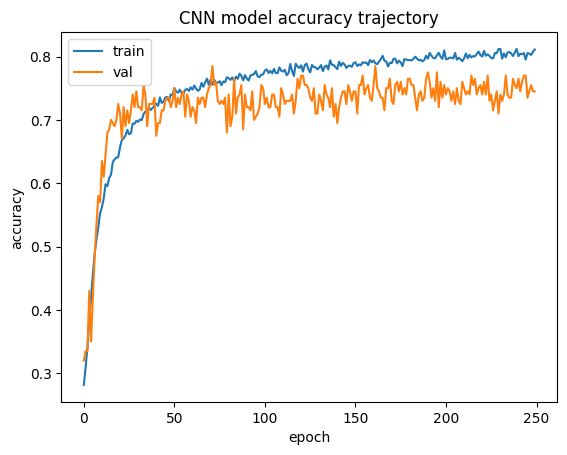

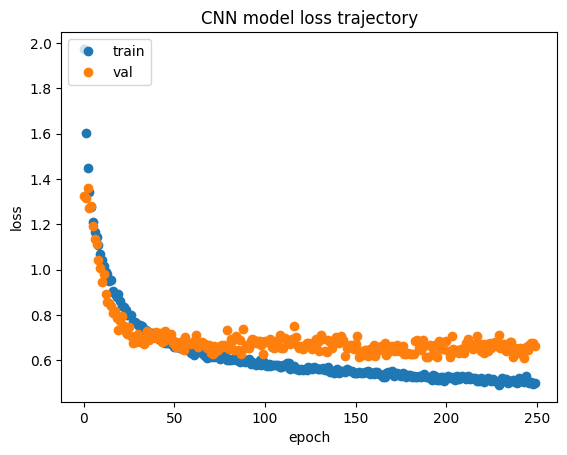

In [7]:
# Plotting accuracy trajectory
plt.plot(cnn_model_results.history['accuracy'])
plt.plot(cnn_model_results.history['val_accuracy'])
plt.title('CNN model accuracy trajectory')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# Plotting loss trajectory
plt.plot(cnn_model_results.history['loss'],'o')
plt.plot(cnn_model_results.history['val_loss'],'o')
plt.title('CNN model loss trajectory')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [8]:
cnn_model_score_all_subjects = cnn_model.evaluate(X_test, y_test, verbose=0)
print("Accuracy Across All Subjects: {score}".format(score=cnn_model_score_all_subjects[1]))

Accuracy Across All Subjects: 0.7110609412193298


In [9]:
# Test the model against each individual subject group
for i in range(9):
  indices = np.where(person_test[:, 0] == i)
  x = X_test[indices]
  y = y_test[indices]
  score = cnn_model.evaluate(x, y, verbose=0)
  print("Subject {subject} Accuracy: {score}".format(subject=i, score=score[1]))

Subject 0 Accuracy: 0.7200000286102295
Subject 1 Accuracy: 0.5400000214576721
Subject 2 Accuracy: 0.800000011920929
Subject 3 Accuracy: 0.6800000071525574
Subject 4 Accuracy: 0.7659574747085571
Subject 5 Accuracy: 0.7142857313156128
Subject 6 Accuracy: 0.699999988079071
Subject 7 Accuracy: 0.7400000095367432
Subject 8 Accuracy: 0.7446808218955994


This model was trained over *all* subjects and was able to achieve a testing accuracy fo 71% over all subjects. With this, the model was also able to perform remarkably well on *individual subjects* as well. One of the key architectural decisions with this classifier was to include a kernel that is more towards a single direction - that is, utilize m x 1 kernels. Whereas in image classification the data *around* a pixel matter significantly in classifying the image, it is more the case that points to the *left and right* of time-series data are relevant in the case of the EEG data.